Download full data set from http://benchmark.ini.rub.de/?section=gtsdb&subsection=dataset

In [1]:
import numpy as np
import cv2

IMG_HEIGHT = 600
SIGN_SIZE = (30, 30)

# Function for reading the images
def readImages(rootpath, images_range, signs_range):
    '''Reads traffic sign data for German Traffic Sign Recognition Benchmark.
    Arguments: path to the traffic sign data, for example 'FullIJCNN2013'
    Returns:   list of images, list of corresponding labels'''
    images = {} # original image
    scales = {} # original scale
    for num in images_range:
        filename = rootpath + '/' + "{:05d}".format(num) + '.ppm'
        img = cv2.imread(filename, cv2.IMREAD_COLOR)
        scale = IMG_HEIGHT / float(img.shape[0])
        img_resized = cv2.resize(img, (int(img.shape[1]*scale),int(img.shape[0]*scale)))
        images.setdefault(filename,[]).append(img_resized)
        scales.setdefault(filename,[]).append(scale)

    files = [] # filenames
    signs = [] # traffic sign image
    bboxes = [] # corresponding box detection
    labels = [] # traffic sign type
    data = np.genfromtxt(rootpath + '/' + 'gt.txt', delimiter=';', dtype=str, usecols=range(0, 6))
    for elem in signs_range:
        filename = rootpath + '/' + data[elem][0]
        img = images.get(filename)[0]
        scale = scales.get(filename)[0]
        bbox = np.array([int(data[elem][1]), int(data[elem][2]), int(data[elem][3]), int(data[elem][4])]) * scale
        sign = img[int(bbox[1]):int(bbox[3]), int(bbox[0]):int(bbox[2])]
        sign_resized = cv2.resize(sign, SIGN_SIZE)
        files.append(filename)
        signs.append(sign_resized)
        bboxes.append(bbox)
        labels.append(data[elem][5])
    return images, files, signs, bboxes, labels

In [2]:
# The German Traffic Sign Recognition Benchmark
train_images, train_files, train_signs, train_bboxes, train_labels = readImages('FullIJCNN2013', range(0,600), range(0,852))
test_images, test_files, test_signs, test_bboxes, test_labels = readImages('FullIJCNN2013', range(600,900), range(852,1213))

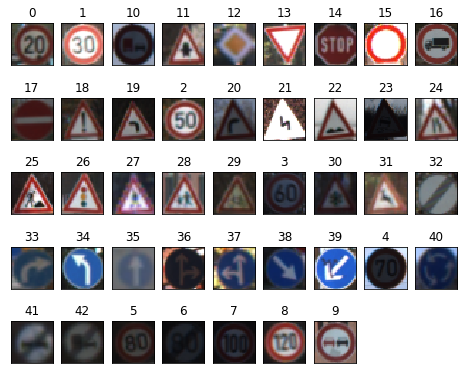

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline 

# Show examples from each class
class_names = np.unique(train_labels)
num_classes = len(class_names)
fig = plt.figure(figsize=(8,8))
for i in range(num_classes):
    ax = fig.add_subplot(6, 9, 1 + i, xticks=[], yticks=[])
    ax.set_title(class_names[i])
    indices = np.where(np.isin(train_labels, class_names[i]))[0]
    plt.imshow(cv2.cvtColor(train_signs[int(np.random.choice(indices, 1))], cv2.COLOR_BGR2RGB))
plt.show()

In [4]:
from sklearn.utils import shuffle
train_files, train_signs, train_bboxes, train_labels = shuffle(train_files, train_signs, train_bboxes, train_labels)
# plt.imshow(cv2.cvtColor(train_images.get(train_files[0])[0], cv2.COLOR_BGR2RGB))
# plt.show()
# plt.imshow(cv2.cvtColor(train_signs[0], cv2.COLOR_BGR2RGB))
# plt.show()
# print(train_bboxes[0])
# print(train_labels[0])

# Data pre-processing
tr_signs = np.array(train_signs)[0:600]
tr_labels = np.array(train_labels)[0:600]
va_signs = np.array(train_signs)[600:852]
va_labels = np.array(train_labels)[600:852]
te_signs = np.array(test_signs)
te_labels = np.array(test_labels)

tr_signs = tr_signs.astype('float32')
va_signs = va_signs.astype('float32')
te_signs = te_signs.astype('float32')
tr_signs /= 255.0
va_signs /= 255.0
te_signs /= 255.0

from keras.utils import np_utils
tr_labels = np_utils.to_categorical(tr_labels, num_classes)
va_labels = np_utils.to_categorical(va_labels, num_classes)
te_labels = np_utils.to_categorical(te_labels, num_classes)

Using TensorFlow backend.


In [5]:
# Tensorboard
from time import time
from keras.callbacks import TensorBoard
tensorboard = TensorBoard(log_dir='logs/{}'.format(time()))

## Convolutional Neural Network classifier

In [6]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D
from keras.optimizers import Adam

cnn = Sequential()

cnn.add(Conv2D(filters=32, strides=(1, 1), kernel_size=(4, 4), padding='same', input_shape=(SIGN_SIZE[0], SIGN_SIZE[1], 3)))
cnn.add(Activation('relu'))
cnn.add(Dropout(0.2))
cnn.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format=None))
cnn.add(Dropout(0.1))

cnn.add(Conv2D(filters=64, strides=(1, 1), kernel_size=(4, 4), padding='same'))
cnn.add(Activation('relu'))
cnn.add(Dropout(0.2))
cnn.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format=None))
cnn.add(Dropout(0.1))

cnn.add(Conv2D(filters=128, strides=(2, 2), kernel_size=(4, 4), padding='same'))
cnn.add(Activation('relu'))
cnn.add(Dropout(0.2))
cnn.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format=None))
cnn.add(Dropout(0.1))


cnn.add(Conv2D(filters=32, strides=(1, 1), kernel_size=(2, 2), padding='same'))
cnn.add(Activation('relu'))
cnn.add(Dropout(0.2))
cnn.add(MaxPooling2D(pool_size=(1, 1), strides=None, padding='valid', data_format=None))
cnn.add(Dropout(0.1))

cnn.add(Flatten())
cnn.add(Dense(1024, activation='relu'))
cnn.add(Dropout(0.3))




cnn.add(Dense(num_classes))
cnn.add(Activation('softmax'))

opt = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=0.00000001, decay=0.0, amsgrad=False)
cnn.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
cnn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 30, 30, 32)        1568      
_________________________________________________________________
activation_1 (Activation)    (None, 30, 30, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 30, 30, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 15, 15, 64)        32832     
_________________________________________________________________
activation_2 (Activation)    (None, 15, 15, 64)        0         
__________

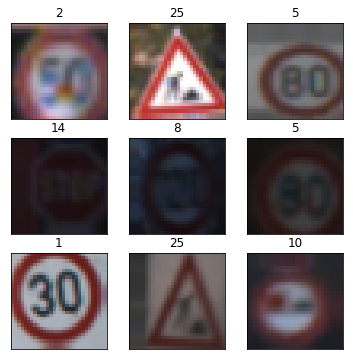

Epoch 1/100
 - 2s - loss: 3.5279 - acc: 0.0552 - val_loss: 3.4774 - val_acc: 0.0754
Epoch 2/100
 - 0s - loss: 3.3912 - acc: 0.0724 - val_loss: 3.3740 - val_acc: 0.1786
Epoch 3/100
 - 0s - loss: 3.2569 - acc: 0.1199 - val_loss: 3.2097 - val_acc: 0.2302
Epoch 4/100
 - 1s - loss: 3.0164 - acc: 0.1853 - val_loss: 2.8877 - val_acc: 0.3016
Epoch 5/100
 - 0s - loss: 2.7216 - acc: 0.2460 - val_loss: 2.6145 - val_acc: 0.3452
Epoch 6/100
 - 0s - loss: 2.4479 - acc: 0.2807 - val_loss: 2.3833 - val_acc: 0.3016
Epoch 7/100
 - 0s - loss: 2.2171 - acc: 0.3192 - val_loss: 2.1796 - val_acc: 0.4246
Epoch 8/100
 - 0s - loss: 2.0406 - acc: 0.3710 - val_loss: 1.9243 - val_acc: 0.3889
Epoch 9/100
 - 0s - loss: 1.9390 - acc: 0.3829 - val_loss: 1.8630 - val_acc: 0.4167
Epoch 10/100
 - 0s - loss: 1.8024 - acc: 0.3998 - val_loss: 1.6623 - val_acc: 0.4921
Epoch 11/100
 - 0s - loss: 1.7154 - acc: 0.4282 - val_loss: 1.6327 - val_acc: 0.4563
Epoch 12/100
 - 0s - loss: 1.5918 - acc: 0.4651 - val_loss: 1.5528 - val_a

Epoch 98/100
 - 0s - loss: 0.1787 - acc: 0.9341 - val_loss: 0.3094 - val_acc: 0.9325
Epoch 99/100
 - 0s - loss: 0.1570 - acc: 0.9541 - val_loss: 0.3889 - val_acc: 0.9246
Epoch 100/100
 - 0s - loss: 0.1785 - acc: 0.9423 - val_loss: 0.2717 - val_acc: 0.9286
CNN took 0.027924537658691406 seconds
Test loss: 0.21517531709472063 - Accuracy: 0.961218836565097


In [7]:
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1
                             ,
                             shear_range=0.2, zoom_range=0.15,
                             fill_mode='nearest')
datagen.fit(tr_signs, augment=True)


for x_batch, y_batch in datagen.flow(tr_signs, tr_labels, batch_size=9):
    # create a grid of 3x3 images
    fig = plt.figure(figsize=(6,6))
    for i in range(0, 9):
        ax = fig.add_subplot(3, 3, 1 + i, xticks=[], yticks=[])
        ax.set_title(np.argmax(y_batch[i]))
        plt.imshow(cv2.cvtColor(x_batch[i], cv2.COLOR_BGR2RGB))
    # show the plot
    plt.show()
    break
    
train_steps = int(len(tr_signs) / 16)
valid_steps = int(len(va_signs) / 16)
data = cnn.fit_generator(datagen.flow(tr_signs, tr_labels, batch_size=32), epochs=100, steps_per_epoch=train_steps, verbose=2, validation_data=(va_signs, va_labels), validation_steps=valid_steps, callbacks=[tensorboard])

start = time()
loss, acc = cnn.evaluate(te_signs, te_labels, verbose=0)
end = time()
print('CNN took ' + str(end - start) + ' seconds')
print('Test loss: ' + str(loss) + ' - Accuracy: ' + str(acc))

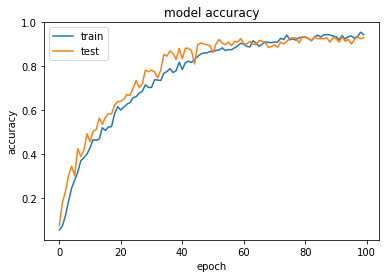

In [8]:
plt.plot(data.history['acc'])
plt.plot(data.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

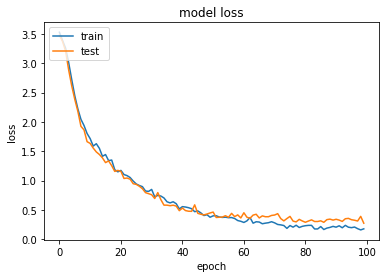

In [9]:
plt.plot(data.history['loss'])
plt.plot(data.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
 cnn.save('classifier_32.h5')  # creates a HDF5 file 'binary_model.h5'